In [64]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import random

### Takes an image of a tissue slice and an image of an epithelium extract from Qupath an inputs

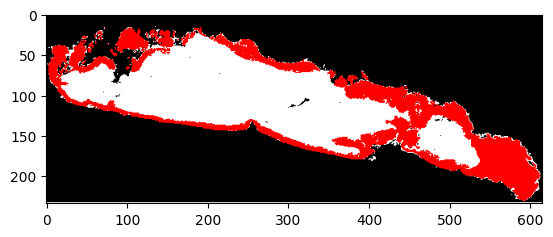

In [123]:
def apply_mask():

    # Open the JPG and PNG images
    jpg_path = '/Users/annaroney/Downloads/Stat390_Anna/QuPath_work/1:22 patching test/data/2/thumbnail.jpg' # path to the tissue slice
    png_mask_path = '/Users/annaroney/Downloads/Stat390_Anna/QuPath_work/1:22 patching test/export/h1857578B  h&e_ROI_2-labels.png' # path to the epithelium slice
    
    jpg_image = Image.open(jpg_path).convert("RGB")
    png_mask = Image.open(png_mask_path).convert("RGBA")

    # Resize the mask to match the JPG dimensions if they differ
    if jpg_image.size != png_mask.size:
        png_mask = png_mask.resize(jpg_image.size, Image.LANCZOS)

    # Convert both images to numpy arrays
    jpg_array = np.array(jpg_image)
    mask_array = np.array(png_mask)

    # Create a mask for the PNG: True where the PNG is not white
    non_white_mask = ~np.all(mask_array[:, :, :3] > 200, axis=-1)  # Mask where PNG is not white

    # Create the final output image with a black background
    final_image_array = np.zeros_like(jpg_array)

    # Add white for stroma: Original white pixels in the JPG
    stroma_mask = np.all(jpg_array > 200, axis=-1)  # White pixels in JPG
    final_image_array[stroma_mask] = [0, 0, 0]  # Set stroma to white

    # Add red for mask: Areas in the PNG mask
    final_image_array[non_white_mask] = [254, 0, 0]  # Set mask areas to red
    mask = final_image_array
    # Set remaining original JPG pixels (not covered by PNG) to black
    non_masked_area = ~(stroma_mask | non_white_mask)  # Pixels not in stroma or mask
    final_image_array[non_masked_area] = [255, 255, 255]  # Set uncovered pixels to black

    # Convert back to PIL image
    final_image = Image.fromarray(final_image_array)

    return final_image, mask


   

image, mask = apply_mask()
filename = '/Users/annaroney/Downloads/Stat390_Anna/QuPath_work/1:22 patching test/epitheliummask.png' # where you want your output to go
image.save(filename)

# Display the final image
plt.imshow(image)
plt.show()

mask[mask == 255] = 0 

## Notes on the following code block:

- Uses Alyssa's code as a base
- makes patches 1.1 * the exact width of the epithelium
    - realistically more than that because value is rounded up
    - that multiplication constant can be edited
- no iteration involved
- currently takes longer to run than Alyssa's initial code

Tissue orientation: horizontal


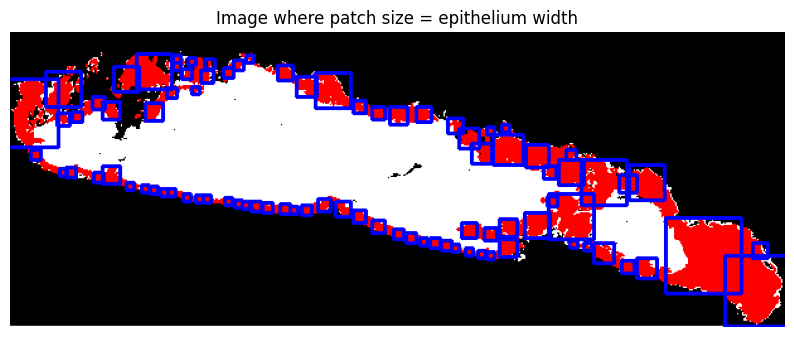

In [128]:
# Load the image
image_path = '/Users/annaroney/Downloads/Stat390_Anna/QuPath_work/1:22 patching test/epitheliummask.png'
image = cv2.imread(image_path)

# Mask for black areas, white areas, and non-black-white pixels
black_mask = cv2.inRange(image, np.array([0, 0, 0]), np.array([0, 0, 0]))
white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))
non_black_white_mask = mask

non_black_white_mask = np.any(non_black_white_mask>0, axis = 2).astype(int)

# Calculate distance to the nearest black and white pixels
black_distance = cv2.distanceTransform(255 - black_mask, cv2.DIST_L2, 3)
white_distance = cv2.distanceTransform(255 - white_mask, cv2.DIST_L2, 3)

# Find coordinates of non-black and non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Define the ratio tolerance range for balanced points
min_ratio, max_ratio = .7, 1.3

# Filter coordinates to only include balanced points
balanced_points = [
    coord for coord in coordinates
    if min_ratio <= (black_distance[coord[0], coord[1]] / white_distance[coord[0], coord[1]]) <= max_ratio
]

# Function to determine tissue orientation
def determine_orientation(mask):
    # Find non-zero epithelium pixels
    non_zero_coords = np.column_stack(np.where(mask > 0))
    y_min, y_max = non_zero_coords[:, 0].min(), non_zero_coords[:, 0].max()
    x_min, x_max = non_zero_coords[:, 1].min(), non_zero_coords[:, 1].max()
    # Compare height and width of the bounding box
    height = y_max - y_min
    width = x_max - x_min
    return "vertical" if height > width else "horizontal"

# Determine tissue orientation
tissue_orientation = determine_orientation(non_black_white_mask)
print(f"Tissue orientation: {tissue_orientation}")

# Updated function to calculate epithelium width
def calculate_epithelium_width(row_or_col, mask, orientation, max_allowed_gaps = 5):
    if orientation == "horizontal":
        # Use vertical slice for horizontally oriented tissue
        slice_mask = mask[:, row_or_col] # looks at the column
    else:
        # Use horizontal slice for vertically oriented tissue
        slice_mask = mask[row_or_col, :] # looks at the row

    # Convert the mask slice to binary
    binary_slice = (slice_mask > 0).astype(int) # pixels along a column of the image where 1 represents epithelium
    #print(binary_slice)
    # new code
    # 1 means change from 0 to 1 and -1 means change from 1 to 0 in the binary slice
    diffs = np.diff(np.concatenate(([0],binary_slice,[0])))
    #print(np.unique(diffs))
    starts = np.where(diffs == 1)[0] # index where epithelium starts in a binary slice (may be more than 1)
    ends = np.where(diffs == -1)[0] # index where epithelium ends (will be array of same length as 'starts')
    widths = np.ceil((ends - starts)*1.1).astype(int) # array of same length as 'starts' and 'ends'
    #print(widths)
    middle_idx = np.floor((starts + ends)/2).astype(int) # index needs to be a whole number
    width_and_idx = np.column_stack((widths, middle_idx))
    #print(width_and_idx)

    # allows a specified number of 0s within the string of 1s for wiggle-room
    width_and_idx = width_and_idx[width_and_idx[:,0]>max_allowed_gaps]
    return width_and_idx

# Initialize variables
max_attempts = 1000
covered_coordinates = set()
rectangles = []
attempts = 0

# Start generating squares using only balanced points as starting locations
while len(balanced_points) > 0 and attempts < 1000:
    attempts += 1
    # Randomly select a new center point for the square from balanced points
    random.seed(attempts)
    random_coord = random.choice(balanced_points)
    center_x, center_y = int(random_coord[1]), int(random_coord[0])

    # Dynamically calculate the initial_size based on epithelium width
    if tissue_orientation == "horizontal":
        width_and_idx = calculate_epithelium_width(center_x, non_black_white_mask, tissue_orientation)

        for w, mid in width_and_idx:
            half_side = w // 2
            left = center_x - half_side
            top = mid - half_side 
            right = center_x + half_side
            bottom = mid + half_side 
            # top needs to be - and bottom needs to be + even though counterintuitive

            # creating a set of new patch coordinates
            square_coords = np.array([(x, y) for x in range(left, right + 1) for y in range(top, bottom + 1)])
            square_coords_set = set(map(tuple, square_coords))

            # Check overlap 
            if len(square_coords_set) == 0:
                overlap = 0
            else:
                overlap = len(square_coords_set.intersection(covered_coordinates)) / len(square_coords_set)

            vertical_preference = False

            # No more expansion phase
            
            # calculate overlap before drawing patch
            if overlap <= 0.2: # if they aren't overlapping that much
                covered_coordinates.update(square_coords_set) # then now we have those coords covered
                rectangles.append((left, top, right, bottom)) # and that becomes a patch

                # Draw the rectangle
                color = (0, 255, 0) if vertical_preference else (255, 0, 0)
                cv2.rectangle(image, (left, top), (right, bottom), color, 2)

                # Remove these coordinates from the balanced points
                remove = np.isin(balanced_points, square_coords).all(axis = 1)
                balanced_points = np.array(balanced_points)
                balanced_points = balanced_points[~remove]

    else: # vertical case
        width_and_idx = calculate_epithelium_width(center_y, non_black_white_mask, tissue_orientation)
    
        square_coords = []

        for w, mid in width_and_idx:
            half_side = w // 2
            left = mid - half_side
            top = center_y - half_side
            right = mid + half_side
            bottom = center_y + half_side
            
            # creating a set of new patch coordinates
            square_coords = np.array([(x, y) for x in range(left, right + 1) for y in range(top, bottom + 1)])
            square_coords_set = set(map(tuple, square_coords))

            # Check overlap 
            if len(square_coords_set) == 0:
                overlap = 0
            else:
                overlap = len(square_coords_set.intersection(covered_coordinates)) / len(square_coords_set)
            vertical_preference = False

            # No more expansion phase
            
            # calculate overlap before drawing patch
            if overlap <= 0.2: # if they aren't overlapping that much
                covered_coordinates.update(square_coords_set) # then now we have those coords covered
                rectangles.append((left, top, right, bottom)) # and that becomes a patch

                # Draw the rectangle
                color = (0, 255, 0) if vertical_preference else (255, 0, 0)
                cv2.rectangle(image, (left, top), (right, bottom), color, 2)

                # Remove these coordinates from the balanced points
                remove = np.isin(balanced_points, square_coords).all(axis = 1)
                balanced_points = np.array(balanced_points)
                balanced_points = balanced_points[~remove]

# Display the resulting image with all rectangles
plt.figure(figsize=(10, 10))
plt.title("Image where patch size = epithelium width")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



In [125]:
lengths = []

# Print dimensions of each final rectangle as Length x Width
for i, (left, top, right, bottom) in enumerate(rectangles, 1):
    length = bottom - top  # Height of the rectangle
    width = right - left   # Width of the rectangle
    lengths.append(length)
    
    print(f"Rectangle {i} dimensions: Length = {length} pixels, Width = {width} pixels")

import statistics as st
print(np.mean(lengths))
print(st.mode(lengths))


Rectangle 1 dimensions: Length = 28 pixels, Width = 28 pixels
Rectangle 2 dimensions: Length = 10 pixels, Width = 10 pixels
Rectangle 3 dimensions: Length = 6 pixels, Width = 6 pixels
Rectangle 4 dimensions: Length = 12 pixels, Width = 12 pixels
Rectangle 5 dimensions: Length = 56 pixels, Width = 56 pixels
Rectangle 6 dimensions: Length = 24 pixels, Width = 24 pixels
Rectangle 7 dimensions: Length = 14 pixels, Width = 14 pixels
Rectangle 8 dimensions: Length = 14 pixels, Width = 14 pixels
Rectangle 9 dimensions: Length = 18 pixels, Width = 18 pixels
Rectangle 10 dimensions: Length = 20 pixels, Width = 20 pixels
Rectangle 11 dimensions: Length = 14 pixels, Width = 14 pixels
Rectangle 12 dimensions: Length = 10 pixels, Width = 10 pixels
Rectangle 13 dimensions: Length = 6 pixels, Width = 6 pixels
Rectangle 14 dimensions: Length = 10 pixels, Width = 10 pixels
Rectangle 15 dimensions: Length = 6 pixels, Width = 6 pixels
Rectangle 16 dimensions: Length = 60 pixels, Width = 60 pixels
Rectang

## Evaluation

In [126]:
# Calculate the total mask area
total_mask_area = np.sum(non_black_white_mask > 0)

# Initialize variables to track patch areas and overlap
total_patch_area = 0            
patch_area_outside_mask = 0     
overlap_area = 0                

patch_masks = [] # stores binary masks for each patch so we can calculate overlaps later

# Loop through each patch defined by its bounding box
for (left, top, right, bottom) in rectangles:

    # Create a binary mask for the current patch
    patch_mask = np.zeros_like(non_black_white_mask, dtype=np.uint8)
    patch_mask[max(0, top):min(image.shape[0], bottom), max(0, left):min(image.shape[1], right)] = 1 # set the region corresponding to the current patch to 1 within image bounds

    # Calculate the area of the current patch
    patch_area = np.sum(patch_mask)
    total_patch_area += patch_area    

    # Calculate the area of the patch that falls outside the mask
    area_outside_mask = np.sum(patch_mask & (non_black_white_mask == 0))
    patch_area_outside_mask += area_outside_mask  

    # Calculate overlap with previously added patches
    for prev_patch in patch_masks:
        overlap_area += np.sum(patch_mask & prev_patch)

    # Add the current patch's binary mask to the list for future overlap calculations
    patch_masks.append(patch_mask)

# Percentage calculations
percent_mask_covered = (total_patch_area - patch_area_outside_mask) / total_mask_area * 100
percent_outside_mask = patch_area_outside_mask / total_patch_area * 100
percent_overlap = overlap_area / total_patch_area * 100

# Number of patches
num_patches = len(rectangles)

# Output results
print(f"% of Mask Area Covered: {percent_mask_covered:.2f}%")
print(f"% of Patch Area Outside Mask: {percent_outside_mask:.2f}%")
print(f"Number of Patches: {num_patches}")
print(f"% Patch Area Overlap: {percent_overlap:.2f}%")

% of Mask Area Covered: 86.78%
% of Patch Area Outside Mask: 27.89%
Number of Patches: 89
% Patch Area Overlap: 4.96%


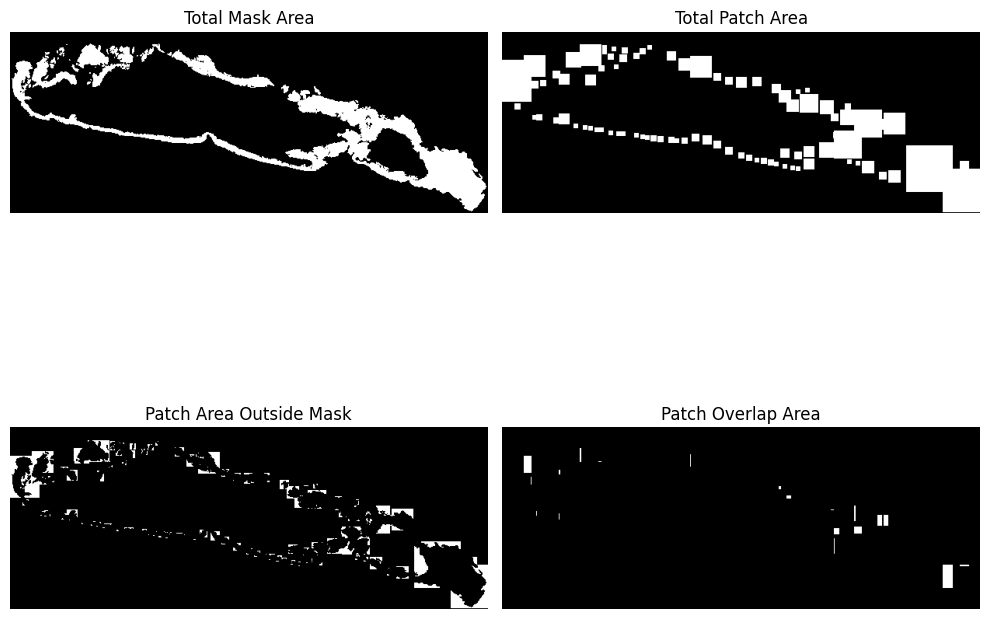

In [127]:
# Create blank images for visualization
mask_visual = non_black_white_mask.copy()
patch_visual = np.zeros_like(non_black_white_mask, dtype=np.uint8)
patch_outside_mask_visual = np.zeros_like(non_black_white_mask, dtype=np.uint8)
patch_overlap_visual = np.zeros_like(non_black_white_mask, dtype=np.uint8)

patch_masks = []  # Store individual patch masks to calculate overlap

for (left, top, right, bottom) in rectangles:
    # Create binary mask for the current patch
    patch_mask = np.zeros_like(non_black_white_mask, dtype=np.uint8)
    patch_mask[max(0, top):min(image.shape[0], bottom), max(0, left):min(image.shape[1], right)] = 255

    # Add patch to total patch visualization
    patch_visual = np.maximum(patch_visual, patch_mask)

    # Ensure mask is in the correct data type and size
    non_black_white_mask_bin = (non_black_white_mask > 0).astype(np.uint8) * 255  # Convert to 0 or 255 (black or white)
    patch_mask_bin = (patch_mask > 0).astype(np.uint8) * 255  # Convert to 0 or 255 (black or white)

    # Ensure both are the same shape
    non_black_white_mask_bin = cv2.resize(non_black_white_mask_bin, (patch_mask_bin.shape[1], patch_mask_bin.shape[0]))

    # Calculate area outside the mask
    outside_mask = cv2.bitwise_and(patch_mask_bin, cv2.bitwise_not(non_black_white_mask_bin))
    patch_outside_mask_visual = np.maximum(patch_outside_mask_visual, outside_mask)

    # Calculate overlapping area with previous patches
    for prev_patch in patch_masks:
        overlap = cv2.bitwise_and(patch_mask, prev_patch)
        patch_overlap_visual = np.maximum(patch_overlap_visual, overlap)

    # Store patch mask
    patch_masks.append(patch_mask)

# Plot the visualizations
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(mask_visual, cmap='gray')
axes[0, 0].set_title("Total Mask Area")

axes[0, 1].imshow(patch_visual, cmap='gray')
axes[0, 1].set_title("Total Patch Area")

axes[1, 0].imshow(patch_outside_mask_visual, cmap='gray')
axes[1, 0].set_title("Patch Area Outside Mask")

axes[1, 1].imshow(patch_overlap_visual, cmap='gray')
axes[1, 1].set_title("Patch Overlap Area")

for ax in axes.flat:
    ax.axis("off")

plt.tight_layout()
plt.show()